# Гиперпараметры и проверка модели

## Хороший способ проверки модели: отложенные данные

In [1]:
# Начнем с загрузки данных:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [4]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

# Мы будем использовать в этом примере классификатор на основе метода k-средних с n_neighbors=1.
# Эту модель можно описать так: "метка для неизвестной точки такая же, как и метка ближайшая к ней обучающей точки"

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Разделяем данные: по 50% в каждом из наборов
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# Обучаем модель на одном из наборов данных
model.fit(X1, y1)

# Оцениваем работу модели на другом наборе
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

Мы получили логичный результат: классификатор на основе метода ближайшего соседа демонстрирует точность около 90% на отложенном наборе данных. Отложенный набор данных схож с неизвестными данными, поскольку модель "не видела" их ранее.

## Прекрасная проверка модели (cross-validation)

Мы выполняем две попытки проверки, попеременно используя каждую половину данных в качестве отложенного набора данных. Воспользовавшись полученными выше разделенными данными, мы можем реализовать это следующим образом:

In [7]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

Полученные числа - две оценки точности, которые можно обобщить (среднее) для получения лучшей меры общей работы модели. Такой метод называется двухблочной перекрестной проверкой (two-fold cross-validation).

In [9]:
# Реализуем пятиблочную перекрестную проверку

from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

## Выбор оптимальной модели

Что делать, если наш оцениватель показывает недостаточно хорошие результаты?

◉ использовать более сложную\гибкую модель;

◉ использовать менее сложную\гибкую модель;

◉ собрать больше выборок для обучения;

◉ собрать больше данных для добавления новых признаков к каждой заданной выборке.

По существу, выбор "оптимальной модели" состоит в поиске наилучшего компромисса между систематической ошибкой (bias) и дисперсией (variance). Рассмотрим рисунок, на котором представлены два случая регриссионной аппроксимации одного набора данных (модели регрессии со значительной систематической ошибкой и высокой дисперсией)((недообученные данные; переобученные данные)):

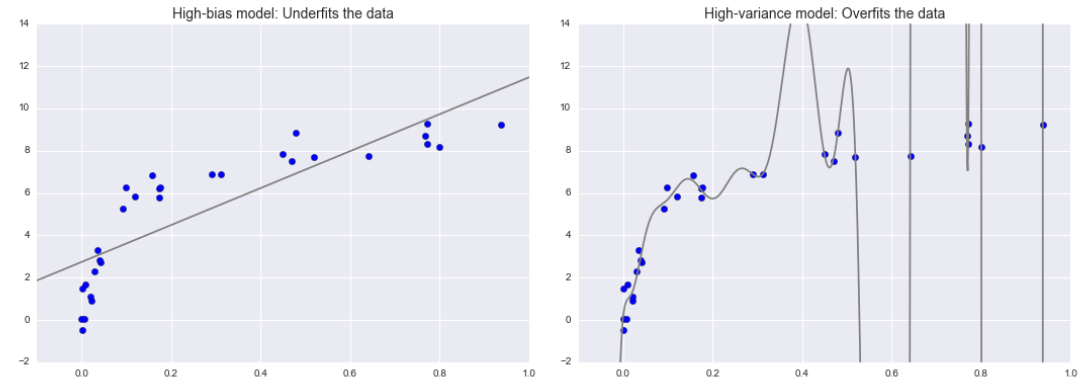

Оценки эффективности модели для обучения и проверки для моделей со значительной систематической ошибкой и высокой дисперсией:

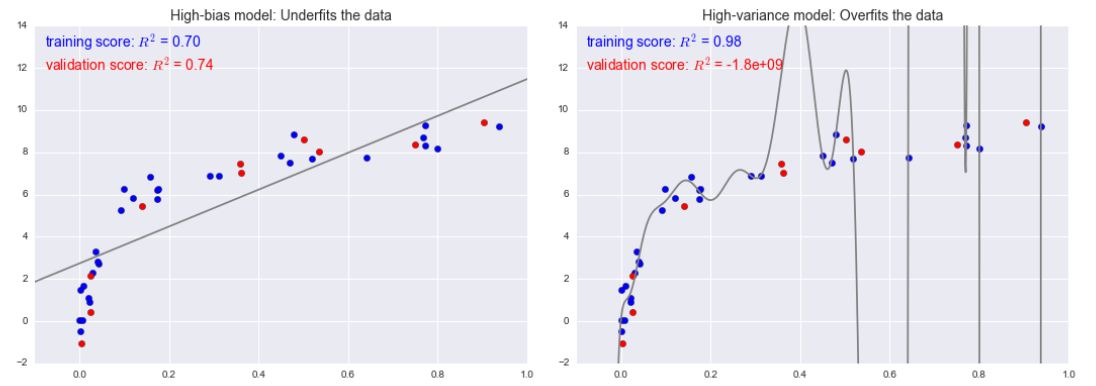

В качестве оценки эффективности используется R^2 - коэффициент детерминации или коэффициент смешанной корреляции. Он представляет собой меру того, насколько хорошо модель работает по сравнению с простым средним значением целевых велечин. R^2=1 означает идеальное совпадение предсказаний, а R2^2=0 показывает, что модель оказалась ничем не лучше простого среднего значения данных, а отрицательные значения указывают на модели, которые работают еще хуже. 

Схематическое изображение зависимости между сложностью и оценками эффективности для обучения и проверки:

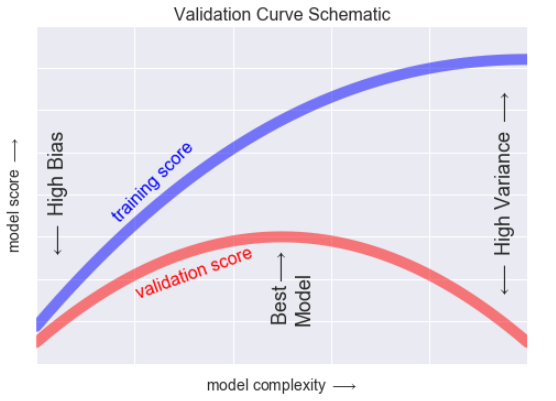

Показанный график часто называют кривой проверки (validation curve).

## Кривые проверки в библиотеке Scikit-Learn

Рассмотрим пример перекрестной проверки для расчета кривой проверки для класса моделей. Мы будем использовать модель полиномиальной регрессии (polynomial regression model): это обобщенная линейная модель с параметризованной степенью многочлена. Например, многочлен 1-й степениаппроксимирует наши данные прямой линией;

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # Создаем случайноые выборки данных
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

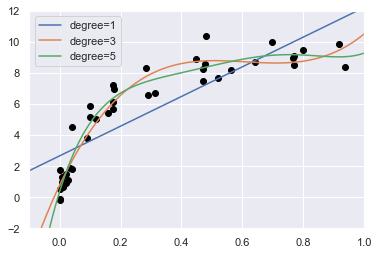

In [12]:
# Визуализируем наши данные вместе с несколькими аппроксимациями их многочленами различной степени 
# (3 различными полиномиальными моделями):

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Какая степень многочлена обеспечивает подходящий компромисс между систематической ошибкой (недообучение) и дисперсией (переобучение)？ Чтобы решить этот вопрос, визуализируем кривую проверки для этих конкретных данных и моделей. Проще всего сделать это с помощью предоставляемой библиотекой Scikit-Learn удобной утилиты validation_curve. Эта функция, получив на входе модель, данные, название параметра и диапазон для анализа, автоматически вычисляет в этом диапазоне значение как оценки эффективности дял обучения, так и оценки эффективности для проверки:

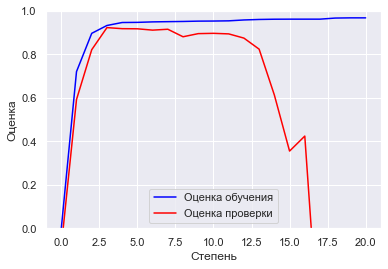

In [23]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, \
                                          param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='Оценка обучения')
plt.plot(degree, np.median(val_score, 1), color='red', label='Оценка проверки')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('Степень')
plt.ylabel('Оценка');

Как можно понять из приведенной кривой проверки, оптимальный компромисс между систематической ошибкой и дисперсией достигается для многочлена третьей степени. Вычислить и отобразить на графике эту аппроксимацию на исходных данных можно следующим образом:

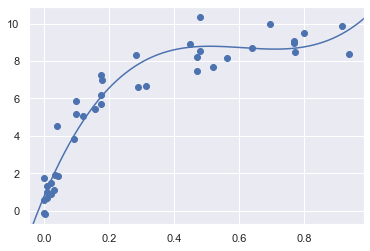

In [24]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## Кривые обучения

Оптимальность модели обычно зависит от размера обучающей последовательности. Например, сгенерируем новый набор данных с количеством точек в пять раз больше и повторим вышеприведенный код для построения графика кривой обучения для этого большого набора данных. Для сравнения выведем поверх и предыдушие результаты:

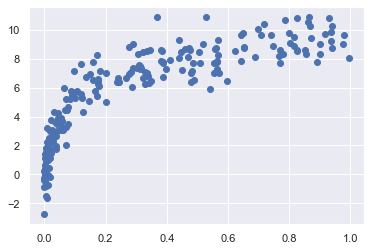

In [25]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

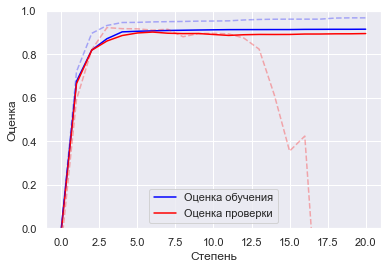

In [28]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='Оценка обучения')
plt.plot(degree, np.median(val_score2, 1), color='red', label='Оценка проверки')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('Степень')
plt.ylabel('Оценка');

Поведение кривой проверки зависит не от одного, а от двух важных факторов: сложности модели и количества точек обучения. Зачастую бывает полезно исследовать поведение модели как функции от количества точек обучения. Сделать это можно путем использования постепенно увеличивающихся подмножеств данных для обучения модели. График оценок для обучения\проверки с учетом размера обучающей последовательности известен под названием кривой обучения (learning curve).

◉ Модель заданной сложности окажется переобученной на слишком маленьком наборе данных. Это значит, что оценка эффективности для   обучения будет относительно высокой, а оценка эффективности для проверки - относительно низкой.

◉ Модель заданной сложности окажется недообученной на слишком большом наборе данных. Это значит, что оценка эффективности для     обучения будет снижаться, а оценка эффективности для проверки - повышаться по мере роста размера набора данных.

◉ Модель никогда, разве что случайно, не покажет на проверочном наборе лучший результат, чем на обучающей последовательности. Это значит, что кривые будут сближаться, но никогда не пересекуться.

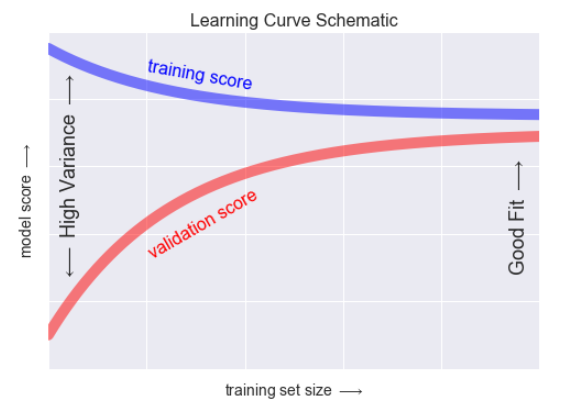

#### Кривые обучения в библиотеке Scikit-Learn.
Библиотека Scikit-Learn предоставляет удобные утилиты для вычисления кривых обучения для моделей. В этом разделе мы вычислим кривую обучения для нашего исходного набора данных с полиномиальными моделями второй и девятой степени:

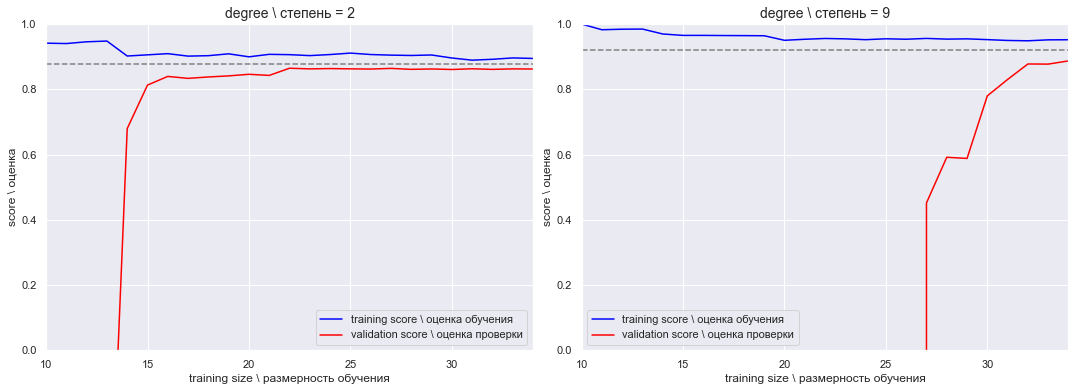

In [31]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score \ оценка обучения')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score \ оценка проверки')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size \ размерность обучения')
    ax[i].set_ylabel('score \ оценка')
    ax[i].set_title('degree \ степень = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## Проверка на практике: поиск по сетке
На практике у моделей обычно больше одного параметра, поэтому графики кривых проверки и обучения превращаются из двумерных линий в многомерные поверхности. Выполнение подобных визуализаций в таких случаях представляет собой непростую задачу, поэтому лучше отыскать конкретную модель, при которой оценка эффективности для проверки достигает максимума.
Библиотека Scikit-Learn предоставляет для этой цели специальные автоматические инструменты, содержащиеся в модуле grid_search. Рассмотрим трехмерную сетку признаков модели - степени многочлена, флага, указывающего нужно ли подбирать точку пересечения с осью координат, и флага, указывающего, следует ли выполнять нормализацию. Выполнить эти настройки можно с помощью мета-оценивателя GridSearchCV:

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Как и обычный оцениватель, он еще небыл применен к каким либо данным. Обучение модели наряду с отслеживанием промежуточных оценок эффективности в каждой из точек сетки производится путем вызова метода fit():

In [37]:
grid.fit(X, y);

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter 

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter 

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter 

In [38]:
# После обучения можно узнать значения оптимальных параметров:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

C:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


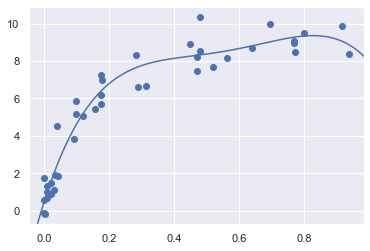

In [40]:
# При необходимости можно воспользоваться этой оптимальной моделью и 
# продемонстрировать аппроксимацию с помощью уже введенного кода:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

# Оптимальная модель, определенная посредством автоматического поиска по сетке: